In [1]:
# --- CELL 1: SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
%matplotlib inline

# Đường dẫn
DATA_DIR = os.path.join('..', 'data')
MODEL_DIR = os.path.join('..', 'model')
os.makedirs(MODEL_DIR, exist_ok=True)

print("👨‍✈️ DRIVER AI: Hệ thống đánh giá năng lực tài xế đã sẵn sàng!")

👨‍✈️ DRIVER AI: Hệ thống đánh giá năng lực tài xế đã sẵn sàng!


In [2]:
# --- CELL 2: LOAD & AGGREGATE DATA ---

# 1. Load các file liên quan đến con người
drivers = pd.read_csv(os.path.join(DATA_DIR, 'drivers.csv'))
safety = pd.read_csv(os.path.join(DATA_DIR, 'safety_incidents.csv'))
metrics = pd.read_csv(os.path.join(DATA_DIR, 'driver_monthly_metrics.csv'))

print(f"🔹 Drivers: {drivers.shape}")
print(f"🔹 Safety Incidents: {safety.shape}")
print(f"🔹 Monthly Metrics: {metrics.shape}")

# 2. Xử lý lịch sử tai nạn (Đếm số vụ)
driver_risk = safety.groupby('driver_id').size().reset_index(name='total_accidents')

# 3. Xử lý KPI (Tính trung bình phong độ của tài xế qua các tháng)
# Lấy trung bình: Tỷ lệ đúng giờ, Số dặm chạy, Mức tiêu hao nhiên liệu
driver_kpi = metrics.groupby('driver_id')[['on_time_delivery_rate', 'total_miles', 'average_mpg']].mean().reset_index()
driver_kpi.rename(columns={
    'on_time_delivery_rate': 'avg_ontime_rate',
    'total_miles': 'avg_miles_per_month',
    'average_mpg': 'avg_mpg'
}, inplace=True)

print("✅ Đã tính toán xong các chỉ số phụ!")
driver_kpi.head()

🔹 Drivers: (150, 12)
🔹 Safety Incidents: (170, 15)
🔹 Monthly Metrics: (4464, 9)
✅ Đã tính toán xong các chỉ số phụ!


,driver_id,avg_ontime_rate,avg_miles_per_month,avg_mpg
0,DRV00001,0.454167,25839.888889,6.484722
1,DRV00002,0.468389,26201.277778,6.505000
2,DRV00003,0.450806,28062.083333,6.539444
3,DRV00004,0.428333,27295.138889,6.517222
4,DRV00005,0.454056,25642.444444,6.512222


In [3]:
# --- CELL 3: MERGE DATA ---

# Lấy bảng drivers làm gốc
master = drivers.copy()

# Ghép thông tin tai nạn
master = master.merge(driver_risk, on='driver_id', how='left')

# Ghép thông tin KPI (Phong độ)
master = master.merge(driver_kpi, on='driver_id', how='left')

# Xử lý dữ liệu thiếu (NaN)
fill_values = {
    'total_accidents': 0,       # Không có tên nghĩa là chưa gây tai nạn
    'avg_ontime_rate': 0.95,    # Mặc định 95% nếu là tài xế mới
    'avg_miles_per_month': 0,
    'avg_mpg': 6.0,
    'years_experience': 1       # Mặc định 1 năm kinh nghiệm
}
master = master.fillna(value=fill_values)

print(f"🎉 Hồ sơ tài xế hoàn chỉnh: {master.shape}")
master.head()

🎉 Hồ sơ tài xế hoàn chỉnh: (150, 16)


,driver_id,first_name,last_name,hire_date,termination_date,license_number,license_state,date_of_birth,home_terminal,employment_status,cdl_class,years_experience,total_accidents,avg_ontime_rate,avg_miles_per_month,avg_mpg
0,DRV00001,Jennifer,Hernandez,2014-10-31,NaN,DL673510887,WA,1973-11-07,Denver,Active,A,3,1.0,0.454167,25839.888889,6.484722
1,DRV00002,William,Martin,2020-10-02,NaN,DL128955006,GA,1976-11-03,Columbus,Active,A,20,2.0,0.468389,26201.277778,6.505000
2,DRV00003,Charles,Hernandez,2021-09-21,NaN,DL523076025,NC,1970-04-06,Salt Lake City,Active,A,19,6.0,0.450806,28062.083333,6.539444
3,DRV00004,Barbara,Brown,2013-09-08,NaN,DL735540030,WA,1995-02-06,Denver,Active,A,19,2.0,0.428333,27295.138889,6.517222
4,DRV00005,Mary,Martinez,2018-12-02,NaN,DL706011277,AZ,1960-07-15,Chicago,Active,A,12,2.0,0.454056,25642.444444,6.512222


In [4]:
# --- CELL 4: LABELING (SỬA LẠI CHO CHUẨN) ---

# Logic đánh giá:
# 1 (Rủi ro): Nếu có BẤT KỲ tai nạn nào (>0) HOẶC Kinh nghiệm quá ít (<2 năm)
# 0 (Tốt): Còn lại

# Ép kiểu dữ liệu cho chắc ăn
master['total_accidents'] = master['total_accidents'].fillna(0).astype(int)
master['years_experience'] = master['years_experience'].fillna(1).astype(int)

# Điều kiện Rủi ro
cond_risky = (master['total_accidents'] > 0) | (master['years_experience'] < 2)

master['driver_rating'] = np.where(cond_risky, 1, 0)

print("📊 Phân bố nhãn Tài xế (0: Giỏi, 1: Rủi ro):")
print(master['driver_rating'].value_counts())

📊 Phân bố nhãn Tài xế (0: Giỏi, 1: Rủi ro):
driver_rating
1    92
0    58
Name: count, dtype: int64


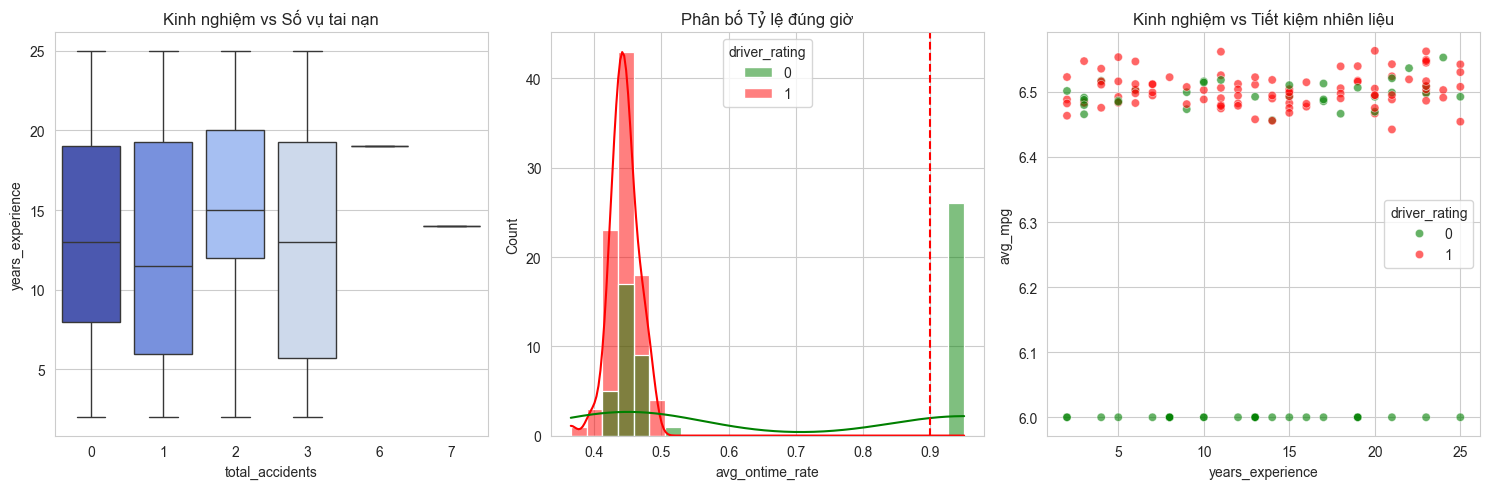

In [5]:
# --- CELL 5: VISUALIZATION (ĐÃ FIX LỖI WARNING) ---

plt.figure(figsize=(15, 5))

# Biểu đồ 1: Kinh nghiệm vs Tai nạn
plt.subplot(1, 3, 1)
# Sửa lỗi: Thêm hue='total_accidents' và legend=False
sns.boxplot(data=master, x='total_accidents', y='years_experience', hue='total_accidents', legend=False, palette='coolwarm')
plt.title('Kinh nghiệm vs Số vụ tai nạn')

# Biểu đồ 2: Tỷ lệ đúng giờ vs Đánh giá
plt.subplot(1, 3, 2)
sns.histplot(data=master, x='avg_ontime_rate', hue='driver_rating', kde=True, palette=['green', 'red'])
plt.title('Phân bố Tỷ lệ đúng giờ')
plt.axvline(0.9, color='red', linestyle='--') # Mốc 90%

# Biểu đồ 3: Mức tiêu hao nhiên liệu vs Kinh nghiệm
plt.subplot(1, 3, 3)
sns.scatterplot(data=master, x='years_experience', y='avg_mpg', hue='driver_rating', palette=['green', 'red'], alpha=0.6)
plt.title('Kinh nghiệm vs Tiết kiệm nhiên liệu')

plt.tight_layout()
plt.show()

In [6]:
# --- CELL 6: PREPARE FOR TRAINING ---

# Chọn các cột Feature (Đầu vào)
features = ['years_experience', 'total_accidents', 'avg_ontime_rate', 'avg_miles_per_month', 'avg_mpg']
X = master[features]
y = master['driver_rating']

# Chia dữ liệu: 80% để học, 20% để thi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📚 Dữ liệu học: {X_train.shape}")
print(f"📝 Dữ liệu thi: {X_test.shape}")

📚 Dữ liệu học: (120, 5)
📝 Dữ liệu thi: (30, 5)


In [7]:
# --- CELL 7: TRAINING WITH TUNING ---

print("🧠 Đang tìm kiếm cấu hình tối ưu cho AI (Grid Search)...")

# Định nghĩa các tham số muốn thử
param_grid = {
    'n_estimators': [50, 100, 200],      # Số lượng cây quyết định
    'max_depth': [None, 10, 20],         # Độ sâu tối đa của cây
    'min_samples_split': [2, 5],         # Số mẫu tối thiểu để tách nhánh
    'class_weight': ['balanced', None]   # Cân bằng dữ liệu nếu bị lệch
}

# Khởi tạo mô hình
rf = RandomForestClassifier(random_state=42)

# Chạy dò tìm (Cross Validation 3 lần)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Lấy ra model ngon nhất
best_model = grid_search.best_estimator_

print(f"🏆 Tham số tốt nhất: {grid_search.best_params_}")
print("✅ Training hoàn tất!")

🧠 Đang tìm kiếm cấu hình tối ưu cho AI (Grid Search)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
🏆 Tham số tốt nhất: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
✅ Training hoàn tất!


🎯 ĐỘ CHÍNH XÁC (ACCURACY): 100.00%

📜 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        22

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


⭐ Top yếu tố ảnh hưởng đến đánh giá:
total_accidents        0.716838
avg_ontime_rate        0.106078
avg_miles_per_month    0.083354
avg_mpg                0.081204
years_experience       0.012527
dtype: float64


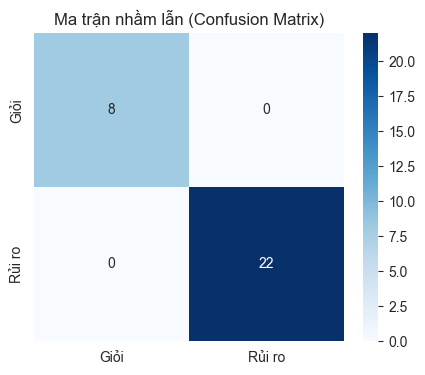

💾 Đã lưu model Driver AI vào: D:\logistics_AI\model\driver_ai.pkl


In [8]:
# --- CELL 8: EVALUATION & EXPORT ---

# Dự đoán thử trên tập Test
y_pred = best_model.predict(X_test)

# 1. Độ chính xác
acc = accuracy_score(y_test, y_pred)
print(f"🎯 ĐỘ CHÍNH XÁC (ACCURACY): {acc*100:.2f}%")

# 2. Báo cáo chi tiết
print("\n📜 Classification Report:")
print(classification_report(y_test, y_pred))

# 3. Feature Importance (Yếu tố nào quan trọng nhất?)
importances = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
print("\n⭐ Top yếu tố ảnh hưởng đến đánh giá:")
print(importances)

# 4. Vẽ Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Giỏi', 'Rủi ro'], yticklabels=['Giỏi', 'Rủi ro'])
plt.title('Ma trận nhầm lẫn (Confusion Matrix)')
plt.show()

# 5. Lưu Model
save_path = os.path.join(MODEL_DIR, 'driver_ai.pkl')
joblib.dump(best_model, save_path)
print(f"💾 Đã lưu model Driver AI vào: {os.path.abspath(save_path)}")